In [1]:
import pandas as pd
from binance.client import Client
import ta

In [2]:
client = Client()

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1MINUTE, start_str="1st November 2021", end_str="1st December 2021")
datas = pd.DataFrame(klines, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore'])
datas['High'] = pd.to_numeric(datas['High'])
datas['Low'] = pd.to_numeric(datas['Low'])
datas['Close'] = pd.to_numeric(datas['Close'])
datas['Open'] = pd.to_numeric(datas['Open'])

datas = datas.set_index(datas['timestamp'])
datas.index = pd.to_datetime(datas.index, unit="ms")

datas = datas.drop(columns=['Volume', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore', 'Closetime'])

In [4]:
import pandas as pd
from binance.client import Client
import ta

In [5]:
client = Client()

startdate = "1st January 2021"

klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1MINUTE, start_str=startdate)
datas = pd.DataFrame(klines, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore'])
datas['High'] = pd.to_numeric(datas['High'])
datas['Low'] = pd.to_numeric(datas['Low'])
datas['Close'] = pd.to_numeric(datas['Close'])
datas['Open'] = pd.to_numeric(datas['Open'])

datas = datas.set_index(datas['timestamp'])
datas.index = pd.to_datetime(datas.index, unit="ms")

datas = datas.drop(columns=['Volume', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore', 'Closetime'])

                         timestamp     Open     High      Low    Close  \
timestamp                                                                
2021-01-01 00:00:00  1609459200000   736.42   737.09   735.94   737.02   
2021-01-01 00:01:00  1609459260000   737.12   739.00   737.06   738.74   
2021-01-01 00:02:00  1609459320000   738.78   738.81   737.35   737.82   
2021-01-01 00:03:00  1609459380000   737.74   738.20   737.28   737.43   
2021-01-01 00:04:00  1609459440000   737.38   737.80   736.80   736.89   
...                            ...      ...      ...      ...      ...   
2021-12-24 10:28:00  1640341680000  4090.62  4090.93  4088.68  4089.00   
2021-12-24 10:29:00  1640341740000  4089.00  4090.00  4088.68  4090.00   
2021-12-24 10:30:00  1640341800000  4090.00  4090.00  4087.57  4089.21   
2021-12-24 10:31:00  1640341860000  4089.20  4091.38  4088.81  4090.92   
2021-12-24 10:32:00  1640341920000  4090.93  4092.35  4089.98  4092.11   

                          SMA      SM

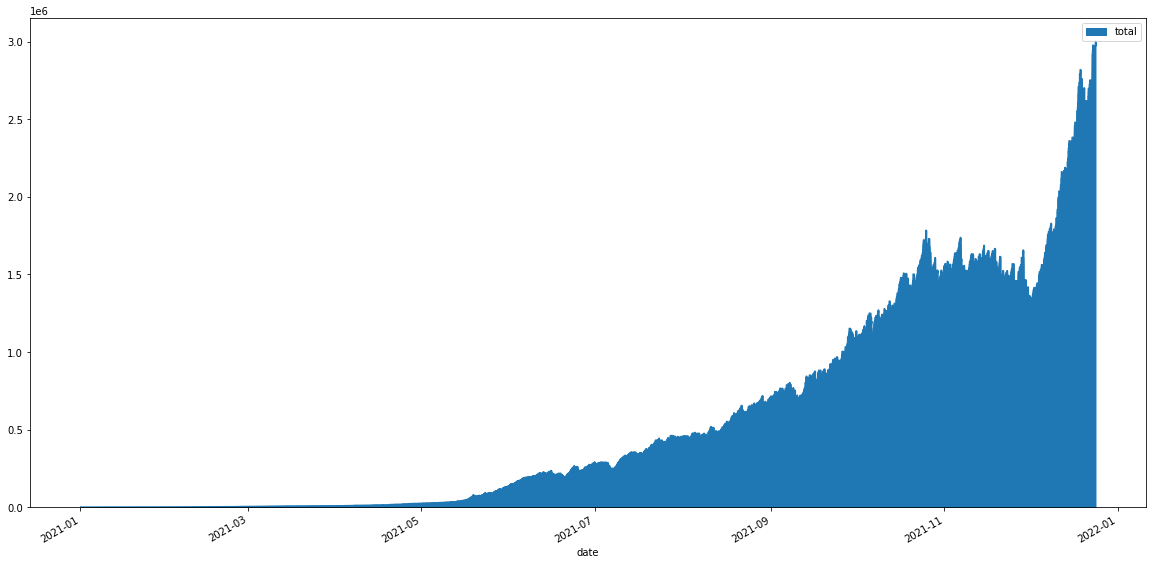

In [6]:
dcp = datas.copy()

smawindow = 10
rsiwindow = 14
smalong = 20
smavlong = 40

dcp["SMA"] = ta.trend.sma_indicator(dcp['Close'], window=smawindow)
dcp["SMA_L"] = ta.trend.sma_indicator(dcp['Close'], window=smalong)
dcp["SMA_VL"] = ta.trend.sma_indicator(dcp['Close'], window=smavlong)

dcp["RSI"] = ta.momentum.rsi(dcp['Close'], window=rsiwindow)

stoch = ta.momentum.StochasticOscillator(dcp['High'], dcp['Low'], dcp['Close'], window=rsiwindow, smooth_window=3)
dcp["STOCH_K"] = stoch.stoch()
dcp["STOCH_D"] = stoch.stoch_signal()
dcp["TREND"] = dcp.iloc[-smalong]["SMA_L"] - dcp["SMA_L"]
print(dcp)


#BOUCLE
usdt = 1000
startusdt = usdt

taxe = 0.004

startcoin = ((usdt * taxe) / dcp.iloc[0]['Close'])
coin = 0

maker = 0.0005

#ETH
sltaux = 0.006
tptaux = 0.002
levier = 5

# #BTC
# sltaux = 0.02
# tptaux = 0.005
# levier = 2

canbuy = True
buytype = 0 # 1 pour long et -1 pour short
oldamount = usdt
shortbuyprice = 0

lastbuytime = dcp.iloc[0].index

bontrade = 0
mauvaistrade = 0

result = None
result = pd.DataFrame(columns=['date', 'type', 'price', 'amount', 'coins', 'frais', 'usdt', 'total'])

plus_haut = usdt
plus_bas = usdt

previousrow = dcp.iloc[0]

def buyLongCondition(row, prev):
  if (row['STOCH_K'] > row['STOCH_D'] and prev['STOCH_K'] < prev['STOCH_D'] and row['STOCH_K'] < 20
    and row["SMA"] > row["Close"]
    and row["RSI"] < 30
    and row["TREND"] > 0
    and row["SMA_L"] < row["SMA_VL"]):
    return True
  else:
    return False

def sellLongCondition(row, prev):
  if (row["RSI"] > 70):
    return True
  else:
    return False

def buyShortCondition(row, prev):
  if (row['STOCH_K'] < row['STOCH_D'] and prev['STOCH_K'] > prev['STOCH_D'] and row['STOCH_K'] > 80
    and row["SMA"] < row["Close"]
    and row["RSI"] > 70
    and row["TREND"] < 0
    and row["SMA_L"] > row["SMA_VL"]):
    return True
  else:
    return False

def sellShortCondition(row):
  if (row["RSI"] < 30):
    return True
  else:
    return False

for x, row in dcp.iterrows():
  #Buy long
  if (buyLongCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice - sltaux * buyprice
    takeprofit = buyprice + tptaux * buyprice
    oldamount = prevusdt

    canbuy = False
    buytype = 1

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY LONG", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  # Buy short
  if (buyShortCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice + sltaux * buyprice
    takeprofit = buyprice - tptaux * buyprice

    canbuy = False
    buytype = -1
    oldamount = prevusdt
    shortbuyprice = buyprice

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY SHORT", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  #StopLoss long
  elif (coin > 0 and buytype == 1 and canbuy == False and stoploss > row['Low']):
    sellprice = stoploss

    percentlost = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas):
      plus_bas = usdt

    print("sl long", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
  
  #StopLoss short
  elif (coin > 0 and buytype == -1 and canbuy == False and stoploss < row['Low']):
    sellprice = stoploss

    percentlost = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas): 
      plus_bas = usdt
    
    print("sl short", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit long
  elif (coin > 0 and buytype == 1 and canbuy == False and takeprofit < row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1
    
    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit short
  elif (coin > 0 and buytype == -1 and canbuy == False and takeprofit > row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt =  oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique long
  elif (canbuy == False and coin > 0 and buytype == 1 and sellLongCondition(row, previousrow) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    # set le min
    if (usdt < plus_bas): plus_bas = usdt

    myrow = {'date': x, 'type': "SELL LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique short
  elif (canbuy == False and coin > 0 and buytype == -1 and sellShortCondition(row) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "SELL SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
    

  previousrow = row


finalv = usdt
if (result.iloc[-1]["type"] in ["BUY SHORT", "BUY LONG"]): finalv = result.iloc[-2]["usdt"]
print("\n")
print("------------ BILAN --------------")
print("\nDonnées entrées pour ce test : ", "\n    Stoploss : ", sltaux, "\n    Takeprofit : ", tptaux, "\n    Levier : ", levier)
print("\nDate de début : ", startdate, "\n\n")
print("USDT AU DEBUT : ", startusdt)
print("USDT A LA FIN : ", finalv)
print("Nombre d'opérations : ", len(result))
print("\n")
print("POURCENTAGE DE GAIN : ", float("{:.1f}".format(((finalv / startusdt) - 1) * 100)), "%")
print("PLUS HAUT MONTANT ATTEINT : ", plus_haut)
print("PLUS BAS MONTANT ATTEINT : ", plus_bas)
print("\n")
print("BONS TRADES : ", bontrade)
print("MAUVAIS TRADES : ", mauvaistrade)
print("\nWin rate : ", float("{:.1f}".format((1-(mauvaistrade / bontrade)) * 100)), "%")
print("\n")
print(result['type'].value_counts())
print("\n")

plot = result.plot(x="date", y="total", kind="area", figsize=(20,10))
print(plot)

print(result)

                         timestamp     Open     High      Low    Close  \
timestamp                                                                
2021-01-01 00:00:00  1609459200000   736.42   737.09   735.94   737.02   
2021-01-01 00:01:00  1609459260000   737.12   739.00   737.06   738.74   
2021-01-01 00:02:00  1609459320000   738.78   738.81   737.35   737.82   
2021-01-01 00:03:00  1609459380000   737.74   738.20   737.28   737.43   
2021-01-01 00:04:00  1609459440000   737.38   737.80   736.80   736.89   
...                            ...      ...      ...      ...      ...   
2021-12-24 10:28:00  1640341680000  4090.62  4090.93  4088.68  4089.00   
2021-12-24 10:29:00  1640341740000  4089.00  4090.00  4088.68  4090.00   
2021-12-24 10:30:00  1640341800000  4090.00  4090.00  4087.57  4089.21   
2021-12-24 10:31:00  1640341860000  4089.20  4091.38  4088.81  4090.92   
2021-12-24 10:32:00  1640341920000  4090.93  4092.35  4089.98  4092.11   

                          SMA      SM

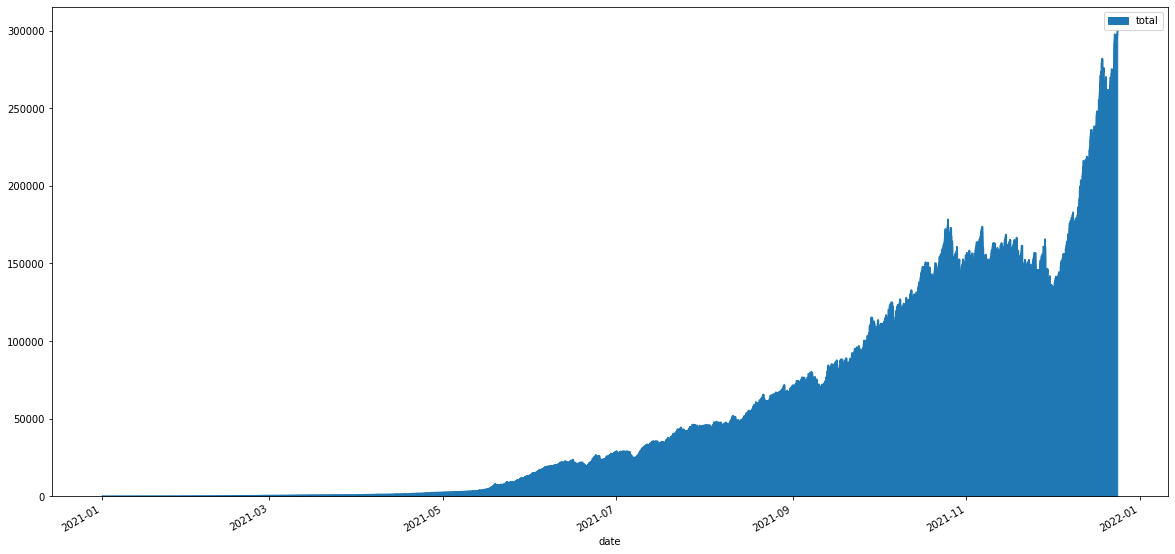

In [7]:
dcp = datas.copy()

smawindow = 10
rsiwindow = 14
smalong = 20
smavlong = 40

dcp["SMA"] = ta.trend.sma_indicator(dcp['Close'], window=smawindow)
dcp["SMA_L"] = ta.trend.sma_indicator(dcp['Close'], window=smalong)
dcp["SMA_VL"] = ta.trend.sma_indicator(dcp['Close'], window=smavlong)

dcp["RSI"] = ta.momentum.rsi(dcp['Close'], window=rsiwindow)

stoch = ta.momentum.StochasticOscillator(dcp['High'], dcp['Low'], dcp['Close'], window=rsiwindow, smooth_window=3)
dcp["STOCH_K"] = stoch.stoch()
dcp["STOCH_D"] = stoch.stoch_signal()
dcp["TREND"] = dcp.iloc[-smalong]["SMA_L"] - dcp["SMA_L"]
print(dcp)


#BOUCLE
usdt = 100
startusdt = usdt

taxe = 0.004

startcoin = ((usdt * taxe) / dcp.iloc[0]['Close'])
coin = 0

maker = 0.0005

#ETH
sltaux = 0.006
tptaux = 0.002
levier = 5

# #BTC
# sltaux = 0.02
# tptaux = 0.005
# levier = 2

canbuy = True
buytype = 0 # 1 pour long et -1 pour short
oldamount = usdt
shortbuyprice = 0

lastbuytime = dcp.iloc[0].index

bontrade = 0
mauvaistrade = 0

result = None
result = pd.DataFrame(columns=['date', 'type', 'price', 'amount', 'coins', 'frais', 'usdt', 'total'])

plus_haut = usdt
plus_bas = usdt

previousrow = dcp.iloc[0]

def buyLongCondition(row, prev):
  if (row['STOCH_K'] > row['STOCH_D'] and prev['STOCH_K'] < prev['STOCH_D'] and row['STOCH_K'] < 20
    and row["SMA"] > row["Close"]
    and row["RSI"] < 30
    and row["TREND"] > 0
    and row["SMA_L"] < row["SMA_VL"]):
    return True
  else:
    return False

def sellLongCondition(row, prev):
  if (row["RSI"] > 70):
    return True
  else:
    return False

def buyShortCondition(row, prev):
  if (row['STOCH_K'] < row['STOCH_D'] and prev['STOCH_K'] > prev['STOCH_D'] and row['STOCH_K'] > 80
    and row["SMA"] < row["Close"]
    and row["RSI"] > 70
    and row["TREND"] < 0
    and row["SMA_L"] > row["SMA_VL"]):
    return True
  else:
    return False

def sellShortCondition(row):
  if (row["RSI"] < 30):
    return True
  else:
    return False

for x, row in dcp.iterrows():
  #Buy long
  if (buyLongCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice - sltaux * buyprice
    takeprofit = buyprice + tptaux * buyprice
    oldamount = prevusdt

    canbuy = False
    buytype = 1

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY LONG", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  # Buy short
  if (buyShortCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice + sltaux * buyprice
    takeprofit = buyprice - tptaux * buyprice

    canbuy = False
    buytype = -1
    oldamount = prevusdt
    shortbuyprice = buyprice

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY SHORT", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  #StopLoss long
  elif (coin > 0 and buytype == 1 and canbuy == False and stoploss > row['Low']):
    sellprice = stoploss

    percentlost = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas):
      plus_bas = usdt

    print("sl long", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
  
  #StopLoss short
  elif (coin > 0 and buytype == -1 and canbuy == False and stoploss < row['Low']):
    sellprice = stoploss

    percentlost = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas): 
      plus_bas = usdt
    
    print("sl short", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit long
  elif (coin > 0 and buytype == 1 and canbuy == False and takeprofit < row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1
    
    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit short
  elif (coin > 0 and buytype == -1 and canbuy == False and takeprofit > row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt =  oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique long
  elif (canbuy == False and coin > 0 and buytype == 1 and sellLongCondition(row, previousrow) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    # set le min
    if (usdt < plus_bas): plus_bas = usdt

    myrow = {'date': x, 'type': "SELL LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique short
  elif (canbuy == False and coin > 0 and buytype == -1 and sellShortCondition(row) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "SELL SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
    

  previousrow = row


finalv = usdt
if (result.iloc[-1]["type"] in ["BUY SHORT", "BUY LONG"]): finalv = result.iloc[-2]["usdt"]
print("\n")
print("------------ BILAN --------------")
print("\nDonnées entrées pour ce test : ", "\n    Stoploss : ", sltaux, "\n    Takeprofit : ", tptaux, "\n    Levier : ", levier)
print("\nDate de début : ", startdate, "\n\n")
print("USDT AU DEBUT : ", startusdt)
print("USDT A LA FIN : ", finalv)
print("Nombre d'opérations : ", len(result))
print("\n")
print("POURCENTAGE DE GAIN : ", float("{:.1f}".format(((finalv / startusdt) - 1) * 100)), "%")
print("PLUS HAUT MONTANT ATTEINT : ", plus_haut)
print("PLUS BAS MONTANT ATTEINT : ", plus_bas)
print("\n")
print("BONS TRADES : ", bontrade)
print("MAUVAIS TRADES : ", mauvaistrade)
print("\nWin rate : ", float("{:.1f}".format((1-(mauvaistrade / bontrade)) * 100)), "%")
print("\n")
print(result['type'].value_counts())
print("\n")

plot = result.plot(x="date", y="total", kind="area", figsize=(20,10))
print(plot)

print(result)

In [8]:
import pandas as pd
from binance.client import Client
import ta

In [9]:
client = Client()

startdate = "1st January 2021"

klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, start_str=startdate)
datas = pd.DataFrame(klines, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore'])
datas['High'] = pd.to_numeric(datas['High'])
datas['Low'] = pd.to_numeric(datas['Low'])
datas['Close'] = pd.to_numeric(datas['Close'])
datas['Open'] = pd.to_numeric(datas['Open'])

datas = datas.set_index(datas['timestamp'])
datas.index = pd.to_datetime(datas.index, unit="ms")

datas = datas.drop(columns=['Volume', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore', 'Closetime'])

                         timestamp      Open      High       Low     Close  \
timestamp                                                                    
2021-01-01 00:00:00  1609459200000  28923.63  28961.66  28913.12  28961.66   
2021-01-01 00:01:00  1609459260000  28961.67  29017.50  28961.01  29009.91   
2021-01-01 00:02:00  1609459320000  29009.54  29016.71  28973.58  28989.30   
2021-01-01 00:03:00  1609459380000  28989.68  28999.85  28972.33  28982.69   
2021-01-01 00:04:00  1609459440000  28982.67  28995.93  28971.80  28975.65   
...                            ...       ...       ...       ...       ...   
2021-12-24 13:22:00  1640352120000  50931.33  50989.00  50930.28  50983.72   
2021-12-24 13:23:00  1640352180000  50983.73  51000.00  50975.62  50983.71   
2021-12-24 13:24:00  1640352240000  50983.71  50998.42  50980.61  50984.99   
2021-12-24 13:25:00  1640352300000  50985.00  50998.41  50975.62  50997.98   
2021-12-24 13:26:00  1640352360000  50997.98  51060.99  50997.97

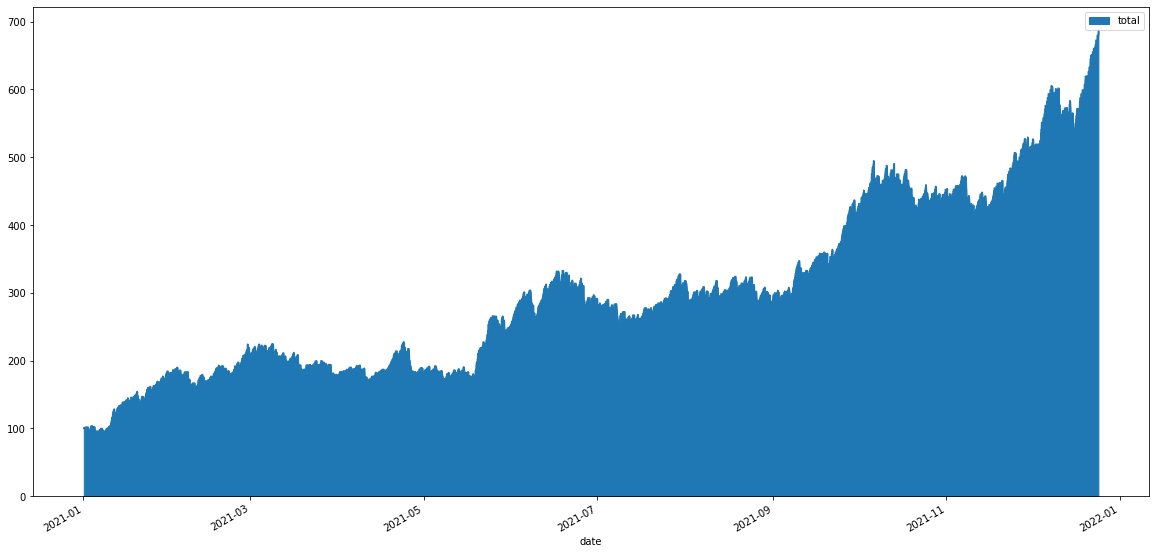

In [10]:
dcp = datas.copy()

smawindow = 10
rsiwindow = 14
smalong = 20
smavlong = 40

dcp["SMA"] = ta.trend.sma_indicator(dcp['Close'], window=smawindow)
dcp["SMA_L"] = ta.trend.sma_indicator(dcp['Close'], window=smalong)
dcp["SMA_VL"] = ta.trend.sma_indicator(dcp['Close'], window=smavlong)

dcp["RSI"] = ta.momentum.rsi(dcp['Close'], window=rsiwindow)

stoch = ta.momentum.StochasticOscillator(dcp['High'], dcp['Low'], dcp['Close'], window=rsiwindow, smooth_window=3)
dcp["STOCH_K"] = stoch.stoch()
dcp["STOCH_D"] = stoch.stoch_signal()
dcp["TREND"] = dcp.iloc[-smalong]["SMA_L"] - dcp["SMA_L"]
print(dcp)


#BOUCLE
usdt = 100
startusdt = usdt

taxe = 0.004

startcoin = ((usdt * taxe) / dcp.iloc[0]['Close'])
coin = 0

#ETH
# sltaux = 0.006
# tptaux = 0.002
# levier = 5

# #BTC
sltaux = 0.02
tptaux = 0.005
levier = 2

canbuy = True
buytype = 0 # 1 pour long et -1 pour short
oldamount = usdt
shortbuyprice = 0

lastbuytime = dcp.iloc[0].index

bontrade = 0
mauvaistrade = 0

result = None
result = pd.DataFrame(columns=['date', 'type', 'price', 'amount', 'coins', 'frais', 'usdt', 'total'])

plus_haut = usdt
plus_bas = usdt

previousrow = dcp.iloc[0]

def buyLongCondition(row, prev):
  if (row['STOCH_K'] > row['STOCH_D'] and prev['STOCH_K'] < prev['STOCH_D'] and row['STOCH_K'] < 20
    and row["SMA"] > row["Close"]
    and row["RSI"] < 30
    and row["TREND"] > 0
    and row["SMA_L"] < row["SMA_VL"]):
    return True
  else:
    return False

def sellLongCondition(row, prev):
  if (row["RSI"] > 70):
    return True
  else:
    return False

def buyShortCondition(row, prev):
  if (row['STOCH_K'] < row['STOCH_D'] and prev['STOCH_K'] > prev['STOCH_D'] and row['STOCH_K'] > 80
    and row["SMA"] < row["Close"]
    and row["RSI"] > 70
    and row["TREND"] < 0
    and row["SMA_L"] > row["SMA_VL"]):
    return True
  else:
    return False

def sellShortCondition(row):
  if (row["RSI"] < 30):
    return True
  else:
    return False

for x, row in dcp.iterrows():
  #Buy long
  if (buyLongCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice - sltaux * buyprice
    takeprofit = buyprice + tptaux * buyprice
    oldamount = prevusdt

    canbuy = False
    buytype = 1

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY LONG", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  # Buy short
  if (buyShortCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice + sltaux * buyprice
    takeprofit = buyprice - tptaux * buyprice

    canbuy = False
    buytype = -1
    oldamount = prevusdt
    shortbuyprice = buyprice

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY SHORT", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  #StopLoss long
  elif (coin > 0 and buytype == 1 and canbuy == False and stoploss > row['Low']):
    sellprice = stoploss

    percentlost = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas):
      plus_bas = usdt

    print("sl long", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
  
  #StopLoss short
  elif (coin > 0 and buytype == -1 and canbuy == False and stoploss < row['Low']):
    sellprice = stoploss

    percentlost = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas): 
      plus_bas = usdt
    
    print("sl short", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit long
  elif (coin > 0 and buytype == 1 and canbuy == False and takeprofit < row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1
    
    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit short
  elif (coin > 0 and buytype == -1 and canbuy == False and takeprofit > row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt =  oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique long
  elif (canbuy == False and coin > 0 and buytype == 1 and sellLongCondition(row, previousrow) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    # set le min
    if (usdt < plus_bas): plus_bas = usdt

    myrow = {'date': x, 'type': "SELL LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique short
  elif (canbuy == False and coin > 0 and buytype == -1 and sellShortCondition(row) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "SELL SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
    

  previousrow = row


finalv = usdt
if (result.iloc[-1]["type"] in ["BUY SHORT", "BUY LONG"]): finalv = result.iloc[-2]["usdt"]
print("\n")
print("------------ BILAN --------------")
print("\nDonnées entrées pour ce test : ", "\n    Stoploss : ", sltaux, "\n    Takeprofit : ", tptaux, "\n    Levier : ", levier)
print("\nDate de début : ", startdate, "\n\n")
print("USDT AU DEBUT : ", startusdt)
print("USDT A LA FIN : ", finalv)
print("Nombre d'opérations : ", len(result))
print("\n")
print("POURCENTAGE DE GAIN : ", float("{:.1f}".format(((finalv / startusdt) - 1) * 100)), "%")
print("PLUS HAUT MONTANT ATTEINT : ", plus_haut)
print("PLUS BAS MONTANT ATTEINT : ", plus_bas)
print("\n")
print("BONS TRADES : ", bontrade)
print("MAUVAIS TRADES : ", mauvaistrade)
print("\nWin rate : ", float("{:.1f}".format((1-(mauvaistrade / bontrade)) * 100)), "%")
print("\n")
print(result['type'].value_counts())
print("\n")

plot = result.plot(x="date", y="total", kind="area", figsize=(20,10))
print(plot)

print(result)

In [11]:
import pandas as pd
from binance.client import Client
import ta

In [12]:
client = Client()

startdate = "1st January 2021"

klines = client.get_historical_klines("BNBUSDT", Client.KLINE_INTERVAL_1MINUTE, start_str=startdate)
datas = pd.DataFrame(klines, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Closetime', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore'])
datas['High'] = pd.to_numeric(datas['High'])
datas['Low'] = pd.to_numeric(datas['Low'])
datas['Close'] = pd.to_numeric(datas['Close'])
datas['Open'] = pd.to_numeric(datas['Open'])

datas = datas.set_index(datas['timestamp'])
datas.index = pd.to_datetime(datas.index, unit="ms")

datas = datas.drop(columns=['Volume', 'QAV', 'NofTrades', 'tbase', 'tquote', 'ignore', 'Closetime'])

                         timestamp      Open      High       Low     Close  \
timestamp                                                                    
2021-01-01 00:00:00  1609459200000   37.3596   37.3702   37.3381   37.3700   
2021-01-01 00:01:00  1609459260000   37.3700   37.4221   37.3487   37.3910   
2021-01-01 00:02:00  1609459320000   37.3905   37.4020   37.3298   37.3311   
2021-01-01 00:03:00  1609459380000   37.3311   37.3367   37.2729   37.2800   
2021-01-01 00:04:00  1609459440000   37.2753   37.2997   37.2502   37.2639   
...                            ...       ...       ...       ...       ...   
2021-12-24 14:27:00  1640356020000  550.5000  550.7000  550.1000  550.6000   
2021-12-24 14:28:00  1640356080000  550.7000  550.9000  550.1000  550.8000   
2021-12-24 14:29:00  1640356140000  550.8000  550.8000  550.2000  550.2000   
2021-12-24 14:30:00  1640356200000  550.3000  551.0000  550.2000  550.5000   
2021-12-24 14:31:00  1640356260000  550.5000  550.7000  550.4000

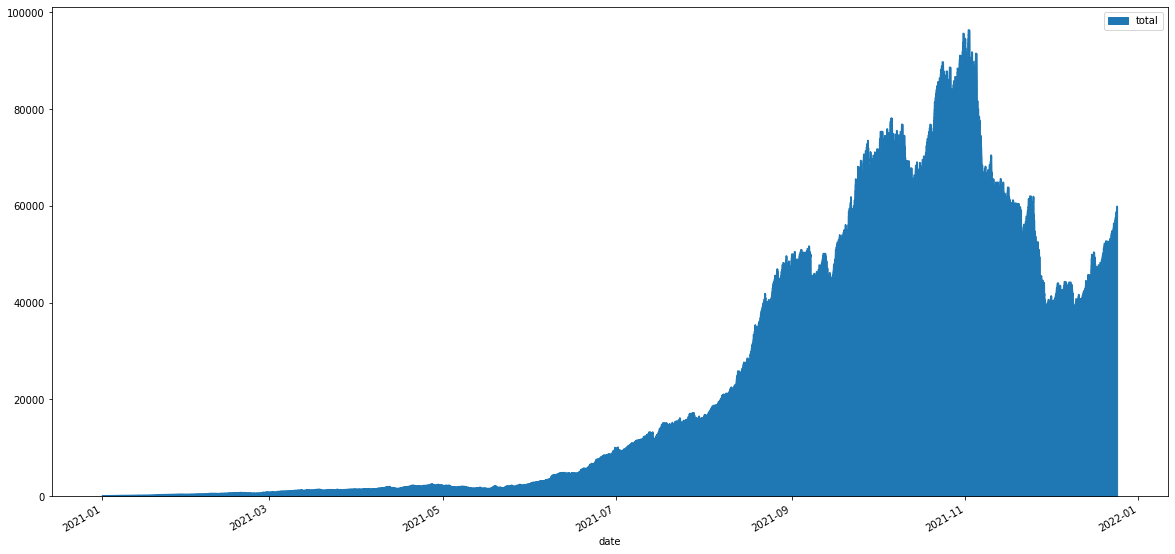

In [13]:
dcp = datas.copy()

smawindow = 10
rsiwindow = 14
smalong = 20
smavlong = 40

dcp["SMA"] = ta.trend.sma_indicator(dcp['Close'], window=smawindow)
dcp["SMA_L"] = ta.trend.sma_indicator(dcp['Close'], window=smalong)
dcp["SMA_VL"] = ta.trend.sma_indicator(dcp['Close'], window=smavlong)

dcp["RSI"] = ta.momentum.rsi(dcp['Close'], window=rsiwindow)

stoch = ta.momentum.StochasticOscillator(dcp['High'], dcp['Low'], dcp['Close'], window=rsiwindow, smooth_window=3)
dcp["STOCH_K"] = stoch.stoch()
dcp["STOCH_D"] = stoch.stoch_signal()
dcp["TREND"] = dcp.iloc[-smalong]["SMA_L"] - dcp["SMA_L"]
print(dcp)


#BOUCLE
usdt = 100
startusdt = usdt

taxe = 0.004

startcoin = ((usdt * taxe) / dcp.iloc[0]['Close'])
coin = 0

#ETH
sltaux = 0.006
tptaux = 0.002
levier = 5

# #BTC
# sltaux = 0.02
# tptaux = 0.005
# levier = 2

canbuy = True
buytype = 0 # 1 pour long et -1 pour short
oldamount = usdt
shortbuyprice = 0

lastbuytime = dcp.iloc[0].index

bontrade = 0
mauvaistrade = 0

result = None
result = pd.DataFrame(columns=['date', 'type', 'price', 'amount', 'coins', 'frais', 'usdt', 'total'])

plus_haut = usdt
plus_bas = usdt

previousrow = dcp.iloc[0]

def buyLongCondition(row, prev):
  if (row['STOCH_K'] > row['STOCH_D'] and prev['STOCH_K'] < prev['STOCH_D'] and row['STOCH_K'] < 20
    and row["SMA"] > row["Close"]
    and row["RSI"] < 30
    and row["TREND"] > 0
    and row["SMA_L"] < row["SMA_VL"]):
    return True
  else:
    return False

def sellLongCondition(row, prev):
  if (row["RSI"] > 70):
    return True
  else:
    return False

def buyShortCondition(row, prev):
  if (row['STOCH_K'] < row['STOCH_D'] and prev['STOCH_K'] > prev['STOCH_D'] and row['STOCH_K'] > 80
    and row["SMA"] < row["Close"]
    and row["RSI"] > 70
    and row["TREND"] < 0
    and row["SMA_L"] > row["SMA_VL"]):
    return True
  else:
    return False

def sellShortCondition(row):
  if (row["RSI"] < 30):
    return True
  else:
    return False

for x, row in dcp.iterrows():
  #Buy long
  if (buyLongCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice - sltaux * buyprice
    takeprofit = buyprice + tptaux * buyprice
    oldamount = prevusdt

    canbuy = False
    buytype = 1

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY LONG", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  # Buy short
  if (buyShortCondition(row, previousrow) == True and canbuy == True and usdt > 0):
    buyprice = row['Close']

    frais = float(usdt * taxe)
    coin = float(usdt / buyprice)
    prevusdt = usdt
    usdt = 0

    stoploss = buyprice + sltaux * buyprice
    takeprofit = buyprice - tptaux * buyprice

    canbuy = False
    buytype = -1
    oldamount = prevusdt
    shortbuyprice = buyprice

    lastbuytime = x

    myrow = {'date': x, 'type': "BUY SHORT", 'price': buyprice, 'amount': prevusdt, 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': oldamount}
    result = result.append(myrow, ignore_index=True)

  #StopLoss long
  elif (coin > 0 and buytype == 1 and canbuy == False and stoploss > row['Low']):
    sellprice = stoploss

    percentlost = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas):
      plus_bas = usdt

    print("sl long", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
  
  #StopLoss short
  elif (coin > 0 and buytype == -1 and canbuy == False and stoploss < row['Low']):
    sellprice = stoploss

    percentlost = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentlost * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    # set le min
    if (usdt < plus_bas): 
      plus_bas = usdt
    
    print("sl short", x, " après avoir acheté le ", lastbuytime)

    mauvaistrade += 1

    myrow = {'date': x, 'type': "STOPLOSS SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit long
  elif (coin > 0 and buytype == 1 and canbuy == False and takeprofit < row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1
    
    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # TakeProfit short
  elif (coin > 0 and buytype == -1 and canbuy == False and takeprofit > row['High']):
    sellprice = takeprofit

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt =  oldamount + (percentprofit * oldamount)
    coin = 0

    canbuy = True
    buytype = 0

    bontrade += 1

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "TAKEPROFIT SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique long
  elif (canbuy == False and coin > 0 and buytype == 1 and sellLongCondition(row, previousrow) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (buyprice / sellprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    # set le max
    if (usdt > plus_haut): plus_haut = usdt

    # set le min
    if (usdt < plus_bas): plus_bas = usdt

    myrow = {'date': x, 'type': "SELL LONG", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)

  # Vente classique short
  elif (canbuy == False and coin > 0 and buytype == -1 and sellShortCondition(row) == True):
    sellprice = row['Close']

    frais = float(coin * taxe)
    sansfrais = coin * sellprice

    percentprofit = (1 - (sellprice / shortbuyprice)) * levier

    usdt = oldamount + (percentprofit * oldamount)
    coin = 0

    if (usdt >= oldamount): bontrade += 1
    else: mauvaistrade += 1

    canbuy = True
    buytype = 0

    if (usdt > plus_haut): plus_haut = usdt

    myrow = {'date': x, 'type': "SELL SHORT", 'price': sellprice, 'amount': "", 'coins': coin, 'frais': float("{:.5f}".format(frais)), 'usdt': usdt, 'total': usdt}
    result = result.append(myrow, ignore_index=True)
    

  previousrow = row


finalv = usdt
if (result.iloc[-1]["type"] in ["BUY SHORT", "BUY LONG"]): finalv = result.iloc[-2]["usdt"]
print("\n")
print("------------ BILAN --------------")
print("\nDonnées entrées pour ce test : ", "\n    Stoploss : ", sltaux, "\n    Takeprofit : ", tptaux, "\n    Levier : ", levier)
print("\nDate de début : ", startdate, "\n\n")
print("USDT AU DEBUT : ", startusdt)
print("USDT A LA FIN : ", finalv)
print("Nombre d'opérations : ", len(result))
print("\n")
print("POURCENTAGE DE GAIN : ", float("{:.1f}".format(((finalv / startusdt) - 1) * 100)), "%")
print("PLUS HAUT MONTANT ATTEINT : ", plus_haut)
print("PLUS BAS MONTANT ATTEINT : ", plus_bas)
print("\n")
print("BONS TRADES : ", bontrade)
print("MAUVAIS TRADES : ", mauvaistrade)
print("\nWin rate : ", float("{:.1f}".format((1-(mauvaistrade / bontrade)) * 100)), "%")
print("\n")
print(result['type'].value_counts())
print("\n")

plot = result.plot(x="date", y="total", kind="area", figsize=(20,10))
print(plot)

print(result)